In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from six.moves import cPickle as pickle

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Test set', (10000, 28, 28), (10000,))
('Validation set', (10000, 28, 28), (10000,))


In [3]:
image_height = 28
image_width = 28
num_labels = 10

train_dataset = train_dataset.reshape((-1, image_height * image_width)).astype(np.float32)
test_dataset = test_dataset.reshape((-1, image_height * image_width)).astype(np.float32)
valid_dataset = valid_dataset.reshape((-1, image_height * image_width)).astype(np.float32)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

('Training set', (200000, 784), (200000,))
('Test set', (10000, 784), (10000,))
('Validation set', (10000, 784), (10000,))


In [4]:
def plot_image(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'Greys', interpolation="nearest")
    plt.axis("off")
    pass

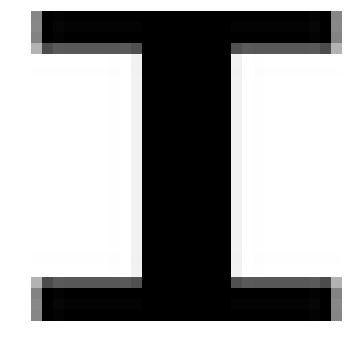

In [5]:
plot_image(train_dataset[1])

In [6]:
train_labels[1]

8

# gradient descent

In [7]:
train_subset = 10000
batch_size = 50
epochs = 101

tf.reset_default_graph()

with tf.name_scope('dnn'):
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :], shape= (10000, image_width * image_height) )
    tf_train_labels = tf.constant(train_labels[:train_subset], shape = (None))
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset = tf.constant(valid_dataset)
    
    weights = tf.Variable(tf.truncated_normal([image_width * image_width, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    train_logits = tf.add(tf.matmul(tf_train_dataset, weights), biases)
    test_logits = tf.add(tf.matmul(tf_test_dataset, weights), biases)
    valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights), biases)
    pass

with tf.name_scope('loss_train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = train_logits, labels=tf_train_labels)
    loss = tf.reduce_mean(xentropy)
    pass

with tf.name_scope('loss'):
    xentropy_valid = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = valid_logits, labels=valid_labels)
    loss_valid = tf.reduce_mean(xentropy_valid, name = 'loss')
    loss_summary_valid = tf.summary.scalar('log_loss', loss_valid)
    pass
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.4)
    training_op = optimizer.minimize(loss)
    pass

with tf.name_scope('eval'):    
    train_predicted = tf.nn.in_top_k(train_logits, tf_train_labels, 1)
    test_predicted = tf.nn.in_top_k(test_logits, test_labels, 1)
    valid_predicted = tf.nn.in_top_k(valid_logits, valid_labels, 1)
    
    train_accuracy = tf.reduce_mean(tf.cast(train_predicted, tf.float32))
    test_accuracy = tf.reduce_mean(tf.cast(test_predicted, tf.float32))
    valid_accuracy = tf.reduce_mean(tf.cast(valid_predicted, tf.float32))
    
    accuracy_summary_valid = tf.summary.scalar('accuracy', valid_accuracy)
    pass

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter('/tmp/notmnist/notmnist_dnn-GD', tf.get_default_graph())

# Train the model

In [9]:
with tf.Session() as sess:
    
    init.run()
    
    for epoch in range(epochs):
        _, accuracy_val, loss_val = sess.run([training_op, train_accuracy, loss])
        test_acc_val = sess.run(test_accuracy)
        
        vaccuracy, vloss, vaccuracy_summary, vloss_summary = sess.run([valid_accuracy, loss_valid, accuracy_summary_valid, loss_summary_valid])
        file_writer.add_summary(vaccuracy_summary, epoch)
        file_writer.add_summary(vloss_summary, epoch)
        
        if epoch % 5 == 0:
            print ('Iteration %d, Train Loss: %.3f, Train Accuracy: %.3f' % (epoch, loss_val, accuracy_val))
            print ('Test Accuracy: %.3f, Validation Accuracy: %.3f' % (test_acc_val, vaccuracy))
            print '\n'
        pass
    save_path = saver.save(sess, "./model1.ckpt")
    pass

Iteration 0, Train Loss: 17.835, Train Accuracy: 0.100
Test Accuracy: 0.112, Validation Accuracy: 0.116


Iteration 5, Train Loss: 8.872, Train Accuracy: 0.234
Test Accuracy: 0.273, Validation Accuracy: 0.264


Iteration 10, Train Loss: 5.687, Train Accuracy: 0.407
Test Accuracy: 0.470, Validation Accuracy: 0.430


Iteration 15, Train Loss: 4.617, Train Accuracy: 0.503
Test Accuracy: 0.562, Validation Accuracy: 0.511


Iteration 20, Train Loss: 4.109, Train Accuracy: 0.552
Test Accuracy: 0.607, Validation Accuracy: 0.550


Iteration 25, Train Loss: 3.795, Train Accuracy: 0.585
Test Accuracy: 0.637, Validation Accuracy: 0.579


Iteration 30, Train Loss: 3.573, Train Accuracy: 0.605
Test Accuracy: 0.659, Validation Accuracy: 0.600


Iteration 35, Train Loss: 3.402, Train Accuracy: 0.623
Test Accuracy: 0.677, Validation Accuracy: 0.614


Iteration 40, Train Loss: 3.264, Train Accuracy: 0.636
Test Accuracy: 0.692, Validation Accuracy: 0.629


Iteration 45, Train Loss: 3.149, Train Accuracy

# stochastic gradient descent

In [10]:
batch_size = 50
epochs = 101

tf.reset_default_graph()

with tf.name_scope('dnn'):
    tf_train_dataset = tf.placeholder(tf.float32, shape = [batch_size, image_width * image_height])
    tf_train_labels = tf.placeholder(tf.int32, shape = (batch_size))
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset = tf.constant(valid_dataset)
    
    weights = tf.Variable(tf.truncated_normal([image_width * image_width, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    train_logits = tf.add(tf.matmul(tf_train_dataset, weights), biases)
    test_logits = tf.add(tf.matmul(tf_test_dataset, weights), biases)
    valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights), biases)
    pass

with tf.name_scope('loss_train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = train_logits, labels=tf_train_labels)
    loss = tf.reduce_mean(xentropy)
    pass
    
with tf.name_scope('loss'):
    xentropy_valid = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = valid_logits, labels=valid_labels)
    loss_valid = tf.reduce_mean(xentropy_valid, name = 'loss')
    loss_summary_valid = tf.summary.scalar('log_loss', loss_valid)
    pass
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.4)
    training_op = optimizer.minimize(loss)
    pass
    
with tf.name_scope('eval'):
    train_predicted = tf.nn.in_top_k(train_logits, tf_train_labels, 1)
    test_predicted = tf.nn.in_top_k(test_logits, test_labels, 1)
    valid_predicted = tf.nn.in_top_k(valid_logits, valid_labels, 1)
    
    train_accuracy = tf.reduce_mean(tf.cast(train_predicted, tf.float32))
    test_accuracy = tf.reduce_mean(tf.cast(test_predicted, tf.float32))
    valid_accuracy = tf.reduce_mean(tf.cast(valid_predicted, tf.float32))
    
    accuracy_summary_valid = tf.summary.scalar('accuracy', valid_accuracy)
    pass

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter('/tmp/notmnist/notmnist_dnn-SGD', tf.get_default_graph())

# Train the model

In [12]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(epochs):
        batch_index = np.random.choice(train_labels.shape[0], batch_size)
        batch_data, batch_labels = train_dataset[batch_index], train_labels[batch_index]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        
        _, accuracy_val, loss_val = sess.run([training_op, train_accuracy, loss], feed_dict=feed_dict)
        test_acc_val = sess.run(test_accuracy)
        
        vaccuracy, vloss, vaccuracy_summary, vloss_summary = sess.run([valid_accuracy, loss_valid, accuracy_summary_valid, loss_summary_valid])
        file_writer.add_summary(vaccuracy_summary, epoch)
        file_writer.add_summary(vloss_summary, epoch)
        
        if epoch % 5 == 0:
            print ('Mini Batch Iteration %d, Train Loss: %.3f, Train Accuracy: %.3f' % (epoch, loss_val, accuracy_val))
            print ('Test Accuracy: %.3f, Validation Accuracy: %.3f' % (test_acc_val, vaccuracy))
            print ('\n')
    save_path = saver.save(sess, "./model2.ckpt")
    pass

Mini Batch Iteration 0, Train Loss: 16.944, Train Accuracy: 0.120
Test Accuracy: 0.146, Validation Accuracy: 0.139


Mini Batch Iteration 5, Train Loss: 7.925, Train Accuracy: 0.300
Test Accuracy: 0.313, Validation Accuracy: 0.282


Mini Batch Iteration 10, Train Loss: 5.159, Train Accuracy: 0.400
Test Accuracy: 0.437, Validation Accuracy: 0.383


Mini Batch Iteration 15, Train Loss: 5.140, Train Accuracy: 0.540
Test Accuracy: 0.498, Validation Accuracy: 0.443


Mini Batch Iteration 20, Train Loss: 5.359, Train Accuracy: 0.480
Test Accuracy: 0.539, Validation Accuracy: 0.481


Mini Batch Iteration 25, Train Loss: 3.928, Train Accuracy: 0.620
Test Accuracy: 0.592, Validation Accuracy: 0.530


Mini Batch Iteration 30, Train Loss: 2.930, Train Accuracy: 0.600
Test Accuracy: 0.638, Validation Accuracy: 0.566


Mini Batch Iteration 35, Train Loss: 4.845, Train Accuracy: 0.480
Test Accuracy: 0.650, Validation Accuracy: 0.580


Mini Batch Iteration 40, Train Loss: 2.695, Train Accuracy: 0.660